# Alzheimer's Classification [Train]

## Config

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

from PIL import Image
from numpy import asarray
import gc
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import pandas as pd
import random
import time
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import StandardScaler
import torchmetrics
import cv2
import pickle
import transformers
import scipy.io.wavfile as wavfile
import datasets as ds
import librosa
import evaluate
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from torchaudio.transforms import SpeedPerturbation
from librosa import effects


from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

/vol/tensusers3/thijsdejong/2324-asr/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class config:
    DEVICE = 'cuda'
    AMP = True
    MAX_GRAD_NORM = 1e7
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = True

    MODEL = "MIT/ast-finetuned-audioset-10-10-0.4593"
    BATCH_SIZE_TRAIN = 4
    BATCH_SIZE_VALID = 4
    EPOCHS = 5
    FOLDS = 5
    VAL_SIZE = .2   # If FOLDS=1 
    WEIGHT_DECAY = 0.1
    MAX_LR = 1e-5
    DROPOUT = 0.85
    
    
class paths:
    OUTPUT_DIR = './output/'
    DATASET = '../datasets/addresso/train/'
    TRANSCRIPT = '../datasets/addresso/train/transcription/'
    AUDIO = '../datasets/addresso/train/concatenated/'

### Utility functions

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger
    
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)
    
LOGGER = get_logger()
seed_everything(config.SEED)

## Loading Data

In [ ]:
df = pd.read_csv(paths.DATASET + 'meta_data.csv')
df = df.drop(columns=['age', 'gender', 'mmse'])
df['audio'] = df['ID'].apply(lambda x: paths.AUDIO +str(x)+'.wav')


In [ ]:
if config.FOLDS > 1:
    gkf = GroupKFold(n_splits=config.FOLDS)
    for fold, (train_index, valid_index) in enumerate(gkf.split(df, df['class'], df['ID'])):
        df.loc[valid_index, "fold"] = int(fold)

df.head()
print(df.groupby(['fold', 'class']).count())

            ID  audio
fold class           
0.0  0      10     10
     1      12     12
1.0  0      11     11
     1      11     11
2.0  0      12     12
     1      10     10
3.0  0      11     11
     1      10     10
4.0  0      10     10
     1      11     11


In [ ]:
class AudioDataset(Dataset):
    def __init__(self, df, mode='train', target_sr=16000):
        self.df = df
        self.mode = mode
        self.f_ex = transformers.AutoFeatureExtractor.from_pretrained(config.MODEL)
        self.target_sr = target_sr

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio']
        audio, sr = librosa.load(audio_path)

        if self.mode == 'train' and False:
          audio = self.speech_augmentation(audio, sr)
        
        features = self.preprocess(audio)
        labels = self.df.iloc[idx]['class']
  
        return features, labels

    def preprocess(self, audio):
        inputs = self.f_ex(audio, sampling_rate=self.target_sr, return_tensors="pt")
        return inputs["input_values"].squeeze(0)

    def speech_augmentation(self, audio, sr):
      # Define probabilities for each augmentation
      noise_prob = 0.3  # 30% chance of adding noise
      pitch_prob = 0.4  # 40% chance of pitch shifting
      volume_prob = 0.5  # 50% chance of volume perturbation
      crop_prob = 0.2  # 20% chance of partial cropping

      if random.random() < pitch_prob:
        audio = self.pitch_shift(audio, sr)
      if random.random() < volume_prob:
        audio = self.volume_perturb(audio)

      noise = np.random.normal(0, 0.01, size=audio.shape)  # Mean = 0, Std = 0.01
      audio += noise

      return audio

    def pitch_shift(self, audio, sr, semitones=random.uniform(-2, 2)):
      return effects.pitch_shift(audio, sr=sr, n_steps=semitones)

    def volume_perturb(self, audio, gain_dB=random.uniform(-3, 3)):
      return effects.preemphasis(audio, coef=gain_dB)


In [ ]:
class AlzheimersModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = transformers.ASTForAudioClassification.from_pretrained(config.MODEL)
        
        self.model_headless = list(self.model.children())[:-1]

        self.backbone = nn.Sequential(*self.model_headless)
        self.fc = nn.Linear(768, 10)
        self.dropout = nn.Dropout(config.DROPOUT)
        self.fc3 = nn.Linear(10,2)

    def forward(self, x):
        out = self.backbone(x)
        out = self.fc(out.pooler_output)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

In [ ]:
print(AlzheimersModel())

AlzheimersModel(
  (model): ASTForAudioClassification(
    (audio_spectrogram_transformer): ASTModel(
      (embeddings): ASTEmbeddings(
        (patch_embeddings): ASTPatchEmbeddings(
          (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ASTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ASTLayer(
            (attention): ASTAttention(
              (attention): ASTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ASTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )


In [ ]:
def train_epoch(train_loader, model, optimizer, epoch, scheduler):
    model.train()
    losses = AverageMeter()
    loss_fn = nn.CrossEntropyLoss()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for idx, (features, labels) in enumerate(tepoch):
            features = np.array(features)
            features = torch.from_numpy(features).to(device)
            labels = labels.to(device)
            batch_size = features.size(0)

            optimizer.zero_grad()
            
            outputs = model(features)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()
            losses.update(loss.item(), batch_size)

    print(f'Train loss: {losses.avg:.4f}')
    return losses.avg


def evaluate(model, valid_loader):
    model.eval()
    losses = AverageMeter()
    acc = AverageMeter()
    auc = torchmetrics.AUROC(task="binary")  # Create the AUC metric
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_probs = torch.tensor([]).to(device)
        all_labels = torch.tensor([]).to(device)
        for idx, (features, labels) in enumerate(valid_loader):
            features = np.array(features)
            features = torch.from_numpy(features).to(device)            
            labels = labels.to(device)
            batch_size = features.size(0)

            outputs = model(features)
            pred = torch.argmax(outputs, 1)
            loss = loss_fn(outputs, labels)
            losses.update(loss.item(), batch_size)

            # Get probabilities for the positive class (Alzheimer's)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs = torch.cat((all_probs, probs), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)

            auc.update(probs, labels) 

            accuracy = torchmetrics.functional.accuracy(pred, labels, 'binary')
            acc.update(accuracy.item(), batch_size)

    roc_auc = auc.compute()
    print(f'Valid loss: {losses.avg:.4f} | Valid accuracy: {acc.avg:.4f} | AUC-ROC: {roc_auc:.4f}')
    return losses.avg, acc.avg, roc_auc, all_probs.cpu().numpy(), all_labels.cpu().numpy()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

all_probs = []
all_labels = []

for fold in range(config.FOLDS):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]

    train_dataset = AudioDataset(train_df, mode='train')
    valid_dataset = AudioDataset(valid_df, mode='test')

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE_TRAIN, shuffle=True, num_workers=config.NUM_WORKERS)
    valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE_VALID, shuffle=False, num_workers=config.NUM_WORKERS)

    model = AlzheimersModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.MAX_LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(optimizer, 
                           max_lr=config.MAX_LR, 
                           epochs=config.EPOCHS, 
                           steps_per_epoch=len(train_loader), 
                           pct_start=0.1,
                           anneal_strategy='cos',
                           div_factor=10,
                           final_div_factor=100
                           )

    train_losses = []
    valid_losses = []
    accs = []
    aucs = []

    for epoch in range(config.EPOCHS):
        print(f'Epoch {epoch}')
        train_loss = train_epoch(train_loader, model, optimizer, epoch, scheduler)

        valid_loss, acc, auc, pr, al = evaluate(model, valid_loader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        accs.append(acc)
        aucs.append(auc.cpu().numpy())


    all_probs.append(pr)
    all_labels.append(al)
    torch.save(model.state_dict(), f'{paths.OUTPUT_DIR}model_{fold}.pth')
    del model, optimizer, scheduler
    gc.collect()
    torch.cuda.empty_cache()
    


Epoch 0


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.8121
Valid loss: 0.7048 | Valid accuracy: 0.5000 | AUC-ROC: 0.5833
Epoch 1


100%|██████████| 22/22 [00:09<00:00,  2.43batch/s]


Train loss: 1.0467
Valid loss: 0.7046 | Valid accuracy: 0.5000 | AUC-ROC: 0.6083
Epoch 2


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.8939
Valid loss: 0.6697 | Valid accuracy: 0.5455 | AUC-ROC: 0.6417
Epoch 3


100%|██████████| 22/22 [00:09<00:00,  2.44batch/s]


Train loss: 0.7557
Valid loss: 0.6433 | Valid accuracy: 0.6364 | AUC-ROC: 0.7667
Epoch 4


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.8289
Valid loss: 0.6431 | Valid accuracy: 0.5455 | AUC-ROC: 0.7333
Epoch 5


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.7524
Valid loss: 0.6461 | Valid accuracy: 0.5909 | AUC-ROC: 0.7250
Epoch 6


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.6083
Valid loss: 0.6329 | Valid accuracy: 0.6364 | AUC-ROC: 0.7417
Epoch 7


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.6279
Valid loss: 0.6586 | Valid accuracy: 0.5455 | AUC-ROC: 0.7917
Epoch 8


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.5614
Valid loss: 0.6270 | Valid accuracy: 0.7273 | AUC-ROC: 0.7833
Epoch 9


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.6238
Valid loss: 0.6105 | Valid accuracy: 0.6818 | AUC-ROC: 0.7917
Epoch 10


100%|██████████| 22/22 [00:09<00:00,  2.37batch/s]


Train loss: 0.5010
Valid loss: 0.6093 | Valid accuracy: 0.6818 | AUC-ROC: 0.7833
Epoch 11


100%|██████████| 22/22 [00:09<00:00,  2.37batch/s]


Train loss: 0.5710
Valid loss: 0.6087 | Valid accuracy: 0.6364 | AUC-ROC: 0.7833
Epoch 12


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.4801
Valid loss: 0.6075 | Valid accuracy: 0.6364 | AUC-ROC: 0.7833
Epoch 13


100%|██████████| 22/22 [00:09<00:00,  2.38batch/s]


Train loss: 0.4931
Valid loss: 0.6071 | Valid accuracy: 0.6818 | AUC-ROC: 0.7917
Epoch 14


100%|██████████| 22/22 [00:09<00:00,  2.36batch/s]


Train loss: 0.4944
Valid loss: 0.6070 | Valid accuracy: 0.6818 | AUC-ROC: 0.7917
Epoch 0


100%|██████████| 22/22 [00:09<00:00,  2.43batch/s]


Train loss: 0.9452
Valid loss: 0.7192 | Valid accuracy: 0.4545 | AUC-ROC: 0.4132
Epoch 1


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 1.0533
Valid loss: 0.7153 | Valid accuracy: 0.5909 | AUC-ROC: 0.5372
Epoch 2


100%|██████████| 22/22 [00:09<00:00,  2.43batch/s]


Train loss: 0.9926
Valid loss: 0.7785 | Valid accuracy: 0.5455 | AUC-ROC: 0.4545
Epoch 3


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.7473
Valid loss: 0.7771 | Valid accuracy: 0.4091 | AUC-ROC: 0.4545
Epoch 4


100%|██████████| 22/22 [00:09<00:00,  2.43batch/s]


Train loss: 0.8299
Valid loss: 0.7901 | Valid accuracy: 0.4545 | AUC-ROC: 0.4628
Epoch 5


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.5375
Valid loss: 0.8069 | Valid accuracy: 0.4545 | AUC-ROC: 0.4380
Epoch 6


100%|██████████| 22/22 [00:08<00:00,  2.45batch/s]


Train loss: 0.6062
Valid loss: 0.8818 | Valid accuracy: 0.5000 | AUC-ROC: 0.4380
Epoch 7


100%|██████████| 22/22 [00:09<00:00,  2.44batch/s]


Train loss: 0.5666
Valid loss: 0.8267 | Valid accuracy: 0.4091 | AUC-ROC: 0.4545
Epoch 8


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.4452
Valid loss: 0.8309 | Valid accuracy: 0.5000 | AUC-ROC: 0.4545
Epoch 9


100%|██████████| 22/22 [00:08<00:00,  2.45batch/s]


Train loss: 0.4340
Valid loss: 0.8182 | Valid accuracy: 0.5000 | AUC-ROC: 0.4876
Epoch 10


100%|██████████| 22/22 [00:09<00:00,  2.42batch/s]


Train loss: 0.4485
Valid loss: 0.8204 | Valid accuracy: 0.5000 | AUC-ROC: 0.5124
Epoch 11


100%|██████████| 22/22 [00:09<00:00,  2.44batch/s]


Train loss: 0.4312
Valid loss: 0.8279 | Valid accuracy: 0.4545 | AUC-ROC: 0.4876
Epoch 12


100%|██████████| 22/22 [00:09<00:00,  2.42batch/s]


Train loss: 0.3534
Valid loss: 0.8519 | Valid accuracy: 0.5000 | AUC-ROC: 0.4793
Epoch 13


100%|██████████| 22/22 [00:09<00:00,  2.44batch/s]


Train loss: 0.4213
Valid loss: 0.8494 | Valid accuracy: 0.5000 | AUC-ROC: 0.4793
Epoch 14


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.3870
Valid loss: 0.8492 | Valid accuracy: 0.4545 | AUC-ROC: 0.4793
Epoch 0


100%|██████████| 22/22 [00:09<00:00,  2.38batch/s]


Train loss: 1.1359
Valid loss: 0.8024 | Valid accuracy: 0.4545 | AUC-ROC: 0.4250
Epoch 1


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.8657
Valid loss: 0.8079 | Valid accuracy: 0.4545 | AUC-ROC: 0.3417
Epoch 2


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.9449
Valid loss: 0.7743 | Valid accuracy: 0.5455 | AUC-ROC: 0.3750
Epoch 3


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.8394
Valid loss: 1.0200 | Valid accuracy: 0.4545 | AUC-ROC: 0.4000
Epoch 4


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.7915
Valid loss: 0.7511 | Valid accuracy: 0.5000 | AUC-ROC: 0.4250
Epoch 5


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.7652
Valid loss: 0.7581 | Valid accuracy: 0.4545 | AUC-ROC: 0.4167
Epoch 6


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.7254
Valid loss: 1.0147 | Valid accuracy: 0.5000 | AUC-ROC: 0.3833
Epoch 7


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.6177
Valid loss: 0.7745 | Valid accuracy: 0.4545 | AUC-ROC: 0.4917
Epoch 8


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.5168
Valid loss: 0.8504 | Valid accuracy: 0.4091 | AUC-ROC: 0.4250
Epoch 9


100%|██████████| 22/22 [00:09<00:00,  2.44batch/s]


Train loss: 0.5415
Valid loss: 0.8035 | Valid accuracy: 0.4091 | AUC-ROC: 0.4333
Epoch 10


100%|██████████| 22/22 [00:09<00:00,  2.42batch/s]


Train loss: 0.4898
Valid loss: 0.8040 | Valid accuracy: 0.4091 | AUC-ROC: 0.4333
Epoch 11


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.4355
Valid loss: 0.8099 | Valid accuracy: 0.4091 | AUC-ROC: 0.4500
Epoch 12


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.3776
Valid loss: 0.8151 | Valid accuracy: 0.4091 | AUC-ROC: 0.4500
Epoch 13


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.3811
Valid loss: 0.8160 | Valid accuracy: 0.4091 | AUC-ROC: 0.4500
Epoch 14


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.4331
Valid loss: 0.8164 | Valid accuracy: 0.4091 | AUC-ROC: 0.4500
Epoch 0


100%|██████████| 22/22 [00:09<00:00,  2.38batch/s]


Train loss: 0.7493
Valid loss: 0.6748 | Valid accuracy: 0.4762 | AUC-ROC: 0.5273
Epoch 1


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.8795
Valid loss: 0.7003 | Valid accuracy: 0.5238 | AUC-ROC: 0.5273
Epoch 2


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.9547
Valid loss: 0.7076 | Valid accuracy: 0.5238 | AUC-ROC: 0.6000
Epoch 3


100%|██████████| 22/22 [00:09<00:00,  2.42batch/s]


Train loss: 0.7808
Valid loss: 0.7920 | Valid accuracy: 0.5238 | AUC-ROC: 0.6091
Epoch 4


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.7506
Valid loss: 0.6747 | Valid accuracy: 0.4762 | AUC-ROC: 0.5636
Epoch 5


100%|██████████| 22/22 [00:09<00:00,  2.42batch/s]


Train loss: 0.7214
Valid loss: 0.6711 | Valid accuracy: 0.4286 | AUC-ROC: 0.5636
Epoch 6


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.5860
Valid loss: 0.6804 | Valid accuracy: 0.4286 | AUC-ROC: 0.5636
Epoch 7


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.4598
Valid loss: 0.6669 | Valid accuracy: 0.5238 | AUC-ROC: 0.5909
Epoch 8


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.4895
Valid loss: 0.6792 | Valid accuracy: 0.5238 | AUC-ROC: 0.6091
Epoch 9


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.4208
Valid loss: 0.6666 | Valid accuracy: 0.6190 | AUC-ROC: 0.6545
Epoch 10


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.5055
Valid loss: 0.6751 | Valid accuracy: 0.6667 | AUC-ROC: 0.6545
Epoch 11


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.4087
Valid loss: 0.6787 | Valid accuracy: 0.6190 | AUC-ROC: 0.6636
Epoch 12


100%|██████████| 22/22 [00:09<00:00,  2.37batch/s]


Train loss: 0.4692
Valid loss: 0.6572 | Valid accuracy: 0.5238 | AUC-ROC: 0.6636
Epoch 13


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.4468
Valid loss: 0.6533 | Valid accuracy: 0.5238 | AUC-ROC: 0.6636
Epoch 14


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.3930
Valid loss: 0.6528 | Valid accuracy: 0.5238 | AUC-ROC: 0.6636
Epoch 0


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.8477
Valid loss: 0.7082 | Valid accuracy: 0.4762 | AUC-ROC: 0.4545
Epoch 1


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 1.0482
Valid loss: 0.6807 | Valid accuracy: 0.6190 | AUC-ROC: 0.5727
Epoch 2


100%|██████████| 22/22 [00:09<00:00,  2.40batch/s]


Train loss: 0.8310
Valid loss: 0.7595 | Valid accuracy: 0.4286 | AUC-ROC: 0.4364
Epoch 3


100%|██████████| 22/22 [00:09<00:00,  2.38batch/s]


Train loss: 0.7113
Valid loss: 0.7591 | Valid accuracy: 0.4286 | AUC-ROC: 0.4818
Epoch 4


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.8053
Valid loss: 0.7066 | Valid accuracy: 0.4286 | AUC-ROC: 0.5364
Epoch 5


100%|██████████| 22/22 [00:09<00:00,  2.36batch/s]


Train loss: 0.5624
Valid loss: 0.7443 | Valid accuracy: 0.4762 | AUC-ROC: 0.5182
Epoch 6


100%|██████████| 22/22 [00:09<00:00,  2.35batch/s]


Train loss: 0.6658
Valid loss: 0.6926 | Valid accuracy: 0.4762 | AUC-ROC: 0.5545
Epoch 7


100%|██████████| 22/22 [00:09<00:00,  2.38batch/s]


Train loss: 0.5207
Valid loss: 0.7409 | Valid accuracy: 0.4762 | AUC-ROC: 0.5091
Epoch 8


100%|██████████| 22/22 [00:09<00:00,  2.36batch/s]


Train loss: 0.4806
Valid loss: 0.7284 | Valid accuracy: 0.5714 | AUC-ROC: 0.4909
Epoch 9


100%|██████████| 22/22 [00:09<00:00,  2.34batch/s]


Train loss: 0.4709
Valid loss: 0.7544 | Valid accuracy: 0.4286 | AUC-ROC: 0.4909
Epoch 10


100%|██████████| 22/22 [00:09<00:00,  2.37batch/s]


Train loss: 0.4349
Valid loss: 0.7905 | Valid accuracy: 0.4762 | AUC-ROC: 0.4727
Epoch 11


100%|██████████| 22/22 [00:09<00:00,  2.35batch/s]


Train loss: 0.4195
Valid loss: 0.7754 | Valid accuracy: 0.4286 | AUC-ROC: 0.4909
Epoch 12


100%|██████████| 22/22 [00:09<00:00,  2.38batch/s]


Train loss: 0.4400
Valid loss: 0.7665 | Valid accuracy: 0.4286 | AUC-ROC: 0.5000
Epoch 13


100%|██████████| 22/22 [00:09<00:00,  2.38batch/s]


Train loss: 0.4425
Valid loss: 0.7685 | Valid accuracy: 0.4286 | AUC-ROC: 0.5000
Epoch 14


100%|██████████| 22/22 [00:09<00:00,  2.37batch/s]


Train loss: 0.4362
Valid loss: 0.7688 | Valid accuracy: 0.4286 | AUC-ROC: 0.5000


In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]

# Save probabilities and labels for each fold in csv
all_probs_n = np.array(flatten(all_probs))
all_labels_n = np.array(flatten(all_labels))
res_df = pd.DataFrame({'probs': all_probs_n, 'labels': all_labels_n})
res_df.to_csv(f'{paths.OUTPUT_DIR}probs_labels.csv', index=False)

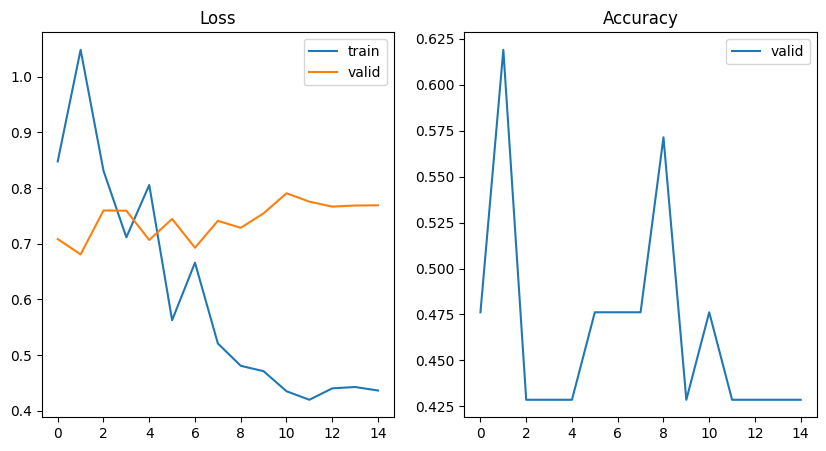

[array([0.47828823, 0.3990889 , 0.56972045, 0.51169187, 0.53885114,
       0.4967405 , 0.36329317, 0.6474085 , 0.34306803, 0.41595227,
       0.73148906, 0.582673  , 0.6225526 , 0.626356  , 0.649239  ,
       0.65320957, 0.59526014, 0.4097039 , 0.48210973, 0.55616134,
       0.44343886, 0.58894295], dtype=float32), array([0.8330304 , 0.818997  , 0.06416773, 0.69031054, 0.20480862,
       0.2842055 , 0.58271986, 0.6319503 , 0.56992775, 0.59955037,
       0.47038049, 0.7473628 , 0.50728744, 0.192592  , 0.40570733,
       0.55183053, 0.09122854, 0.8051468 , 0.6980444 , 0.49978155,
       0.30024052, 0.87632585], dtype=float32), array([0.6269255 , 0.58755827, 0.67870903, 0.57154995, 0.75621647,
       0.6135392 , 0.1123328 , 0.7051713 , 0.35669714, 0.3844581 ,
       0.5866367 , 0.33865896, 0.7319071 , 0.4444561 , 0.3926747 ,
       0.3476807 , 0.7015635 , 0.5304706 , 0.65111   , 0.14047971,
       0.62110364, 0.298394  ], dtype=float32), array([0.5563515 , 0.316937  , 0.5426535 , 0.319476

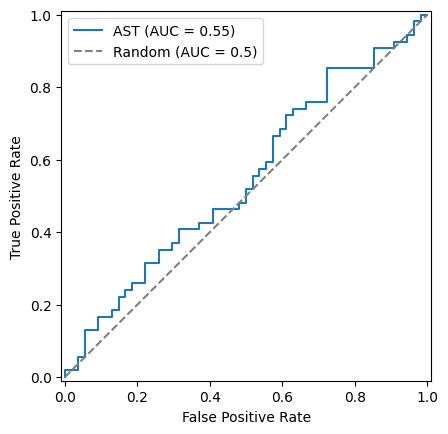

In [ ]:
# Plot training and validation loss and acc
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(accs, label='valid')
plt.legend()
plt.title('Accuracy')
plt.show()

def flatten(xss):
    return [x for xs in xss for x in xs]

print(all_probs, all_labels)

fpr, tpr, thresholds = roc_curve(flatten(all_labels), flatten(all_probs))
auc_roc = roc_auc_score(flatten(all_labels), flatten(all_probs))

# fpr, tpr, thresholds = roc_curve(all_labels[0], all_probs[0])
# auc_roc = roc_auc_score(all_labels[0], all_probs[0])

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc, estimator_name='AST')
display.plot()

# Add AUC = 0.5 line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.5)')

# Show the plot with legend
plt.legend()
plt.show()

# Save the plot
# plt.savefig(f'{paths.OUTPUT_DIR}roc_curve.png')
